In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import xml.etree.ElementTree as ET
from torch.autograd import Variable
from torch import optim

In [2]:
def get_labels(base,name):
    labels = []
    tree = ET.parse(base+name)
    root = tree.getroot()
    for child in root:
        if child.tag == 'object':
            for obj in child:
                if obj.tag == 'name':
                    labels.append(obj.text)

    return sorted(list(set(labels)))

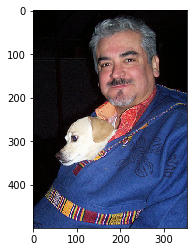

In [3]:
images_path = "../VOCdevkit/VOC2007/JPEGImages/"
annotations_path= "../VOCdevkit/VOC2007/Annotations/"
image_filenames = os.listdir(images_path)
train_images = []
train_labels = []
unique_labels = {}
for filename in image_filenames:
    my_image = Image.open(images_path + filename)
    train_images.append(my_image.copy())
    my_image.close()

    my_labels = get_labels(annotations_path,filename.split(".")[0]+'.xml')

    for label in my_labels:
        if label not in unique_labels:
            unique_labels[label] = len(unique_labels)
    
    my_labels = [unique_labels[label] for label in my_labels]
    
    train_labels.append(my_labels)
            
    
plt.imshow(np.asarray(train_images[0]))

In [4]:
train_labels[:10]

[[0, 1], [2], [3, 4], [5], [3, 6, 7], [3], [8, 1], [9], [10], [11, 5, 1]]

In [5]:
unique_labels

{'dog': 0,
 'person': 1,
 'train': 2,
 'chair': 3,
 'sofa': 4,
 'car': 5,
 'diningtable': 6,
 'pottedplant': 7,
 'horse': 8,
 'cat': 9,
 'cow': 10,
 'bus': 11,
 'bicycle': 12,
 'motorbike': 13,
 'bird': 14,
 'tvmonitor': 15,
 'sheep': 16,
 'aeroplane': 17,
 'boat': 18,
 'bottle': 19}

In [6]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
train_images = [transform(i) for i in train_images]


In [7]:
one_hot_train_labels = []
for labels in train_labels:
    one_hot = [0 for i in range(len(unique_labels))]
    for index in labels:
        one_hot[index] = 1
    one_hot_train_labels.append(torch.Tensor(one_hot))
    
one_hot_train_labels = torch.stack(one_hot_train_labels)
one_hot_train_labels

tensor([[1., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [8]:
train_data = []
for i in range(len(train_images)):
    train_data.append([train_images[i], one_hot_train_labels[i]])

In [9]:
train_split = 0.8
train_data, validation_data = torch.utils.data.random_split(train_data, [int(train_split*len(train_data)), len(train_data) - int(train_split*len(train_data))])

In [10]:
batch_size = 20
num_classes = len(unique_labels)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_data_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=False)

In [11]:
def train(data_loader, classifier, loss_function, optimizer, threshold=0.5):
    classifier.train()
    
    loss = 0
    losses = []
    
    precision = 0
    precisions = []
    
    recall = 0
    recalls = []
    
    f1_score = 0
    f1_scores = []
    
    iou = 0
    ious = []
    
    for i, (images, labels) in enumerate(data_loader):
        
#         if this is the final batch in this epoch and is not a full batch, skip it
        if(images.shape[0] != batch_size):
            break
        
        images = images.cuda()
#         print(images.shape)
        labels = labels.cuda()
#         print(labels)
#         labels = [torch.Tensor(label).cuda() for label in labels]
        
    
        optimizer.zero_grad()
        predictions = classifier(images)

        loss = loss_function(predictions, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        for batch in range(batch_size):
#             getting predictions > threshold
            predicted_labels = [index for index in range(len(predictions[0])) if torch.sigmoid(predictions[batch][index]) > threshold]
            true_labels = [index for index in range(len(labels[0])) if labels[batch][index] == 1]

            intersection = [index for index in range(len(predictions[0])) if (index in predicted_labels) and (index in true_labels)]
            union = [index for index in range(len(predictions[0])) if (index in predicted_labels) or (index in true_labels)]

            try:
                precision = len(intersection)/len(predicted_labels)
            except:
                precision = 0
            precisions.append(precision)

            recall = len(intersection)/len(true_labels)
            recalls.append(recall)

            try:
                f1_score = (2*precision*recall)/(precision + recall)
            except:
                f1_score = 0
            f1_scores.append(f1_score)

            iou = len(intersection) / len(union)
            ious.append(iou)
        
#         if (i + 1) % 50 == 0:
#             print("train accuracy", sum(accuracies)/len(accuracies))
#             print("predictions, labels", [(torch.sigmoid(predictions[0][i]).item(), labels[0][i].item()) for i in range(len(predictions[0]))])
#             print(predictions[0], labels[0])
#             print("true labels:", true_labels)
#             print("pred greater than 0.5:", predicted_labels)
        
    return sum(losses)/len(losses), sum(precisions)/len(precisions), sum(recalls)/len(recalls), sum(f1_scores)/len(f1_scores), sum(ious)/len(ious), losses, ious

def validate(data_loader, classifier, loss_function, threshold=0.5):
    classifier.eval()
    
    loss = 0
    losses = []
    
    precision = 0
    precisions = []
    
    recall = 0
    recalls = []
    
    f1_score = 0
    f1_scores = []
    
    iou = 0
    ious = []
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):

            if(images.shape[0] != batch_size):
                break

            images = images.cuda()
            labels = labels.cuda()

            optimizer.zero_grad()
            predictions = classifier(images)

            loss = loss_function(predictions, labels)
            losses.append(loss.item())

            for batch in range(batch_size):
    #             getting predictions > threshold
                predicted_labels = [index for index in range(len(predictions[0])) if torch.sigmoid(predictions[batch][index]) > threshold]
                true_labels = [index for index in range(len(labels[0])) if labels[batch][index] == 1]
            
                intersection = [index for index in range(len(predictions[0])) if (index in predicted_labels) and (index in true_labels)]
                union = [index for index in range(len(predictions[0])) if (index in predicted_labels) or (index in true_labels)]
                
                try:
                    precision = len(intersection)/len(predicted_labels)
                except:
                    precision = 0
                precisions.append(precision)
                
                recall = len(intersection)/len(true_labels)
                recalls.append(recall)
                
                try:
                    f1_score = (2*precision*recall)/(precision + recall)
                except:
                    f1_score = 0
                f1_scores.append(f1_score)
                
                iou = len(intersection) / len(union)
                ious.append(iou)

#             if (i + 1) % 50 == 0:
#                 print("validation accuracy", sum(accuracies)/len(accuracies))
    #             print(predictions[0], labels[0])
    #             print("true labels:", true_labels)
    #             print("pred greater than 0.5:", predicted_labels)
        
    return sum(losses)/len(losses), sum(precisions)/len(precisions), sum(recalls)/len(recalls), sum(f1_scores)/len(f1_scores), sum(ious)/len(ious), losses, ious

In [15]:
# Hyperparameters
epochs = 50
threshold = 0.5
learning_rate = 0.01
momentum = 0.9
selected_model = "Resnet18"

In [16]:
if selected_model == "Alexnet":
    # Alexnet
    model = models.alexnet(pretrained=True)

    for parameter in model.parameters():
        parameter.requires_grad = False

    fc_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(fc_features, num_classes)
    classifier = model.to(torch.device("cuda:0"))

    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(classifier.classifier[-1].parameters(), lr=learning_rate, momentum=momentum)

elif selected_model == "Resnet18":
    # Resnet18
    model = models.resnet18(pretrained=True)

    for parameter in model.parameters():
        parameter.requires_grad = False

    fc_features = model.fc.in_features
    model.fc = nn.Linear(fc_features, num_classes)
    classifier = model.to(torch.device("cuda:0"))

    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(classifier.fc.parameters(), lr=learning_rate, momentum=momentum)

elif selected_model == "Googlenet":
    # Inception V3
    model = models.googlenet(pretrained=True)

    for parameter in model.parameters():
        parameter.requires_grad = False

    fc_features = model.fc.in_features
    model.fc = nn.Linear(fc_features, num_classes)
    classifier = model.to(torch.device("cuda:0"))

    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(classifier.fc.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
print("Training on", selected_model)
for epoch in range(0, epochs):
    print("starting epoch:", epoch + 1)
    training_loss, training_precision, training_recall, training_f1_score, training_iou, training_losses, training_ious = train(train_data_loader, classifier, loss_function, optimizer, threshold)
    print("Results for epoch", epoch + 1)
    print("training_loss:", training_loss)
    print("training_iou:", training_iou)
    print("training_recall:", training_recall)
    print("training_precision:", training_precision)
    print("training_f1_score:", training_recall, "\n")
    
    validation_loss, validation_precision, validation_recall, validation_f1_score, validation_iou, validation_losses, validation_ious  = validate(validation_data_loader, classifier, loss_function, threshold)
    print("validation_loss:", validation_loss)
    print("validation_iou:", validation_iou)
    print("validation_recall:", validation_recall)
    print("validation_precision:", validation_precision)
    print("validation_f1_score:", validation_recall, "\n\n")

Training on Resnet18
starting epoch: 1
Results for epoch 1
training_loss: 0.21147509513780324
training_iou: 0.212306676063918
training_recall: 0.21860690235690283
training_precision: 0.33011102673981463
training_f1_score: 0.21860690235690283 

validation_loss: 0.14654599267001056
validation_iou: 0.38751700680272094
validation_recall: 0.4012585034013604
validation_precision: 0.5284013605442176
validation_f1_score: 0.4012585034013604 


starting epoch: 2
